In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.basemap import Basemap
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import dateutil.parser
from sklearn.cross_validation import cross_val_score
from sklearn.utils import resample

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
data_file = '~/Documents/Udacity/My Projects/capstone/earthquakes_20170113.csv'
df = pd.read_csv(data_file, dtype={"publicid": str})

# Drop values less than 1800s due to datetime limitations
df=df.drop(df.index[586892: ])

#df = df[pd.notnull(df["eventtype"])] """Most likely are earthquakes

#Remove event type rows with these values - not related to tectonic earthquakes
df = df[df.eventtype != "snow avalanche"]
df = df[df.eventtype != "outside of network interest"]
df = df[df.eventtype != "landslide"]
df = df[df.eventtype != "sonic boom"]
df = df[df.eventtype != "debris avalanche"]
df = df[df.eventtype != "not locatable"]
df = df[df.eventtype != "quarry blast"]
df = df[df.eventtype != "explosion"]
df = df[df.eventtype != "duplicate"]
df = df[df.eventtype != "volcanic eruption"]
df = df[df.eventtype != "nuclear explosion"]
df = df[df.eventtype != "induced earthquake"]
df = df[df.eventtype != "other"]

df = df.drop(df.columns[[0,1,3,8,9,10,11,12,13,14,15,16,17,18,19,20]], axis=1)

#Remove these magnitudes values - data was not measured accurately

df = df[df.magnitude >= 0]

In [2]:
data_file = '~/Documents/Udacity/My Projects/capstone/earthquakes_20170113.csv'
df = pd.read_csv(data_file, dtype={"publicid": str})

In [3]:
df.head()

,publicid,eventtype,origintime,modificationtime,longitude,latitude,magnitude,depth,magnitudetype,depthtype,...,evaluationstatus,evaluationmode,earthmodel,usedphasecount,usedstationcount,magnitudestationcount,minimumdistance,azimuthalgap,originerror,magnitudeuncertainty
0,2018p033731,NaN,2018-01-13T11:32:01.243Z,2018-01-13T11:33:51.276Z,173.786363,-42.207544,2.173616,25.156250,M,NaN,...,NaN,automatic,nz3drx,10,10,3,0.278353,174.672084,0.319559,0.0
1,2018p033726,NaN,2018-01-13T11:29:52.885Z,2018-01-13T11:31:45.788Z,177.681062,-38.648667,1.524821,11.796875,M,NaN,...,NaN,automatic,nz3drx,11,11,8,0.083011,99.309728,0.233182,0.0
2,2018p033712,NaN,2018-01-13T11:22:13.324Z,2018-01-13T11:23:58.188Z,175.578970,-39.188565,0.198787,5.468750,M,NaN,...,NaN,automatic,nz3drx,10,10,4,0.020722,224.083273,0.660573,0.0
3,2018p033711,NaN,2018-01-13T11:21:17.372Z,2018-01-13T12:06:42.303Z,173.748415,-42.052923,2.610453,20.468750,M,NaN,...,NaN,automatic,nz3drx,41,41,18,0.350288,130.130715,1.384927,0.0
4,2018p033704,NaN,2018-01-13T11:17:55.805Z,2018-01-13T11:20:20.927Z,177.439327,-37.307541,2.372378,39.687500,M,NaN,...,NaN,automatic,nz3drx,33,33,18,0.513686,178.268084,0.734280,0.0


In [5]:
# Split timestamp date out for conversion from ISO 8610 to seconds
ISO_8610 = df['origintime']
raw_features = df.drop('origintime', axis = 1)


# Converting the ISO 8601 timestamp to seconds
seconds = []
for x in ISO_8610:
    y = dateutil.parser.parse(x).strftime('%s')
    seconds.append(y)
    
raw_features['origintime_s'] = seconds

In [6]:
display(raw_features.head())

,longitude,latitude,magnitude,depth,origintime_s
0,173.786363,-42.207544,2.173616,25.156250,1515810721
1,177.681062,-38.648667,1.524821,11.796875,1515810592
2,175.578970,-39.188565,0.198787,5.468750,1515810133
3,173.748415,-42.052923,2.610453,20.468750,1515810077
4,177.439327,-37.307541,2.372378,39.687500,1515809875


In [7]:
quakes = []
for x in raw_features.magnitude:
    if x < 5:
        quakes.append(0)
    else:
        quakes.append(1)
raw_features['quakes'] = quakes
raw_features = raw_features.drop('magnitude', axis= 1)

In [8]:
display(raw_features.head())

,longitude,latitude,depth,origintime_s,quakes
0,173.786363,-42.207544,25.156250,1515810721,0
1,177.681062,-38.648667,11.796875,1515810592,0
2,175.578970,-39.188565,5.468750,1515810133,0
3,173.748415,-42.052923,20.468750,1515810077,0
4,177.439327,-37.307541,39.687500,1515809875,0


In [9]:
#UPSAMPLEING TEST

quakes_majority = raw_features[raw_features.quakes==0]
quakes_minority = raw_features[raw_features.quakes==1]

quakes_minority_upsampled = resample(quakes_minority, replace=True, n_samples=566934, random_state=42)

In [20]:
quakes_upsampled = pd.concat([quakes_majority, quakes_minority_upsampled])

In [10]:
quakes_upsampled.quakes.value_counts()

NameError: name 'quakes_upsampled' is not defined

In [ ]:
# Split quake data into features and target label

quake_lables = quakes_upsampled['quakes']
quake_features = quakes_upsampled.drop('quakes', axis = 1)

In [ ]:
display(quake_lables.head())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(quake_features, quake_lables, test_size = 0.3, random_state = 42)


# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

***The next box is a naive predictor and its accuracy

In [26]:
# Calculating accuracy, precision and recall
accuracy = np.sum(quakes) / float(len(quakes))
recall = np.sum(quakes) / float(np.sum(quakes) + 0)
precision = np.sum(quakes) / float(np.sum(quakes) + quakes.count(0))

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
# HINT: The formula above can be written as (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
beta = 0.5
fscore = ((1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall))

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))


Naive Predictor: [Accuracy score: 0.0039, F-score: 0.0049]


In [2]:
clf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state = 42)
results = {}
    
    

clf = clf.fit(X_train[:500], y_train[:500])
        
# TODO: Get the predictions on the test set(X_test),
#       then get predictions on the first 300 training samples(X_train) using .predict()
    
predictions_test = clf.predict(X_test[:500])
predictions_train = clf.predict(X_train[:500])
    
           
# TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
results['acc_train'] = accuracy_score(y_train[:500], predictions_train)
        
# TODO: Compute accuracy on test set using accuracy_score()
results['acc_test'] = accuracy_score(y_test[:500], predictions_test)
    
# TODO: Compute F-score on the the first 300 training samples using fbeta_score()
results['f_train'] = fbeta_score(y_train[:500], predictions_train, 0.5)
        
# TODO: Compute F-score on the test set which is y_test
results['f_test'] = fbeta_score(y_test[:500], predictions_test,0.5)
       
# Success
#print ("{} trained on {} samples.".format(clf.__class__.__name__, sample_size))
        
print (results)

NameError: name 'RandomForestClassifier' is not defined

In [33]:
#print(cross_val_score(clf, X_train, y_train, cv=100))
#print("MEAN")
print (np.mean(cross_val_score(clf, X_train, y_train, cv=100)))

KeyboardInterrupt: 

In [1]:
print(clf.feature_importances_)

NameError: name 'clf' is not defined

In [ ]:
#OOB ERROR
n_estimators = 100


for i in range(1,n_estimators + 1):
    clf.set_params(n_estimators=i)
    clf.fit(X_train, y_train)
    print (i, clf.oob_score_)

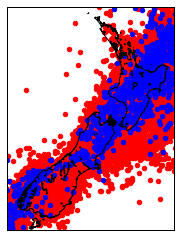

In [4]:
#map focused on NZ

m = Basemap(projection='merc', lat_0 = -41, lon_0 = 175,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=165.58, llcrnrlat=-47.33,
    urcrnrlon=179, urcrnrlat=-33.72)
 
#map.fillcontinents(color = 'coral')

lons = df.longitude[df.magnitude < 5] #All earthquakes less that 5 magnitude
lats = df.latitude[df.magnitude < 5]


lons1 = df.longitude[df.magnitude >= 5] #All earthquakes 5 and over magnitude
lats1 = df.latitude[df.magnitude >= 5]


m.drawcoastlines()
x, y = m(lons.values,lats.values)  # .values as needs to be in an array
m.scatter(x,y,20,color='red')  # Number is point size
x1, y1 =m(lons1.values, lats1.values)
m.scatter(x1,y1,20,color='blue')

 
plt.show()

In [ ]:
print (df.origintime[df.magnitude > 8])

In [ ]:
lons.tail()

In [ ]:
lons.values

In [ ]:
df['longitude'].describe()

In [ ]:
quakes_raw = df['magnitude']
features_raw = df.drop('magnitude', axis=1)
                       
